# CS156 (Introduction to AI), Spring 2021
# <u>Homework 9 submission</u>

## Roster Name: Azael Zamora
## Student ID: 013528931
## Email address: azael.zamora@sjsu.edu

## <u>References and sources</u>

* CNN.Dog_vs_cat_images.ipynb
* https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
* https://www.kaggle.com/alxmamaev/flowers-recognition

In [1]:
import tensorflow as tf
from tensorflow.keras import backend
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
np.random.seed(42)

In [3]:
image_size = (180, 180)
batch_size = 32

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'flowers/test/',
    labels = 'inferred',
    label_mode = 'categorical',
    seed = 42,
    image_size = image_size,
    batch_size = 1
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'flowers/training/',
    labels = 'inferred',
    label_mode = 'categorical',
    validation_split = 0.2,
    subset = 'training',
    seed = 42,
    image_size = image_size,
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'flowers/training/',
    labels = 'inferred',
    label_mode = 'categorical',
    validation_split = 0.2,
    subset = 'validation',
    seed = 42,
    image_size = image_size,
    batch_size = batch_size
)

Found 861 files belonging to 5 classes.
Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.


In [4]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


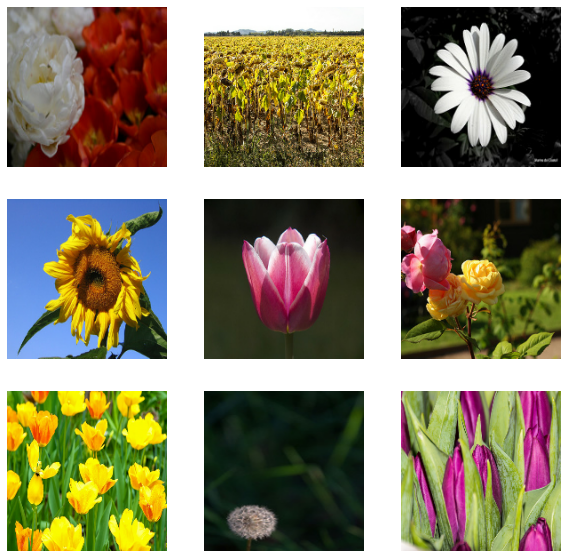

In [5]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [7]:
train_ds = train_ds.prefetch(buffer_size = 32)
val_ds = val_ds.prefetch(buffer_size = 32)

def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape = input_shape)
    
    # Image augmentation block
    x = data_augmentation(inputs)
    
    # Entry block
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = tf.keras.layers.Conv2D(32, 3, strides = 2, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(64, 3, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [128, 256, 512, 728]:
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding = 'same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        x = tf.keras.layers.MaxPooling2D(3, strides = 2, padding = 'same')(x)
        
        residual = tf.keras.layers.Conv2D(size, 1, strides = 2, padding = 'same')(
            previous_block_activation
        )
        
        x = tf.keras.layers.add([x, residual])
        previous_block_activation = x
    
    x = tf.keras.layers.SeparableConv2D(1024, 3, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    activation = 'sigmoid'
    
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(units, activation = activation)(x)
    return tf.keras.Model(inputs, outputs)

In [8]:
model = make_model(input_shape = image_size + (3,), num_classes = 5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

In [9]:
epoch_num = 30

#callbacks = [
#    tf.keras.callbacks.ModelCheckpoint('save_at_{epoch}.hs')
#]

model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.fit(
    train_ds,
    epochs = epoch_num,
    validation_data = val_ds
)

Epoch 1/30
87/87 [==============================] - 250s 3s/step - loss: 1.4790 - accuracy: 0.4415 - val_loss: 1.6555 - val_accuracy: 0.2590
Epoch 2/30
87/87 [==============================] - 240s 3s/step - loss: 1.1427 - accuracy: 0.5785 - val_loss: 2.0955 - val_accuracy: 0.2590
Epoch 3/30
87/87 [==============================] - 238s 3s/step - loss: 0.9390 - accuracy: 0.6467 - val_loss: 2.7291 - val_accuracy: 0.2590
Epoch 4/30
87/87 [==============================] - 240s 3s/step - loss: 0.8999 - accuracy: 0.6555 - val_loss: 3.2041 - val_accuracy: 0.2590
Epoch 5/30
87/87 [==============================] - 239s 3s/step - loss: 0.8581 - accuracy: 0.6689 - val_loss: 3.3168 - val_accuracy: 0.2590
Epoch 6/30
87/87 [==============================] - 239s 3s/step - loss: 0.8044 - accuracy: 0.6945 - val_loss: 2.2013 - val_accuracy: 0.2981
Epoch 7/30
87/87 [==============================] - 239s 3s/step - loss: 0.7679 - accuracy: 0.6952 - val_loss: 0.9183 - val_accuracy: 0.6397
Epoch 8/30
87

In [10]:
true_labels = []
predicted_labels = []

for images, labels in test_ds:
    predict = model.predict(images)
    score = np.argmax(predict)
    
    real = np.argmax(labels)
    
    predicted_labels.append(score)
    true_labels.append(real)

cm = tf.math.confusion_matrix(labels = true_labels, predictions = predicted_labels).numpy()

In [11]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

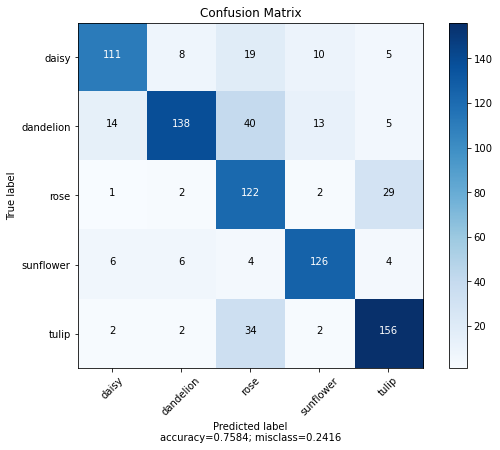

In [12]:
plot_confusion_matrix(cm, normalize = False, target_names = class_names, title = 'Confusion Matrix')

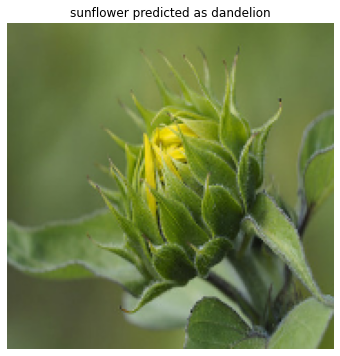

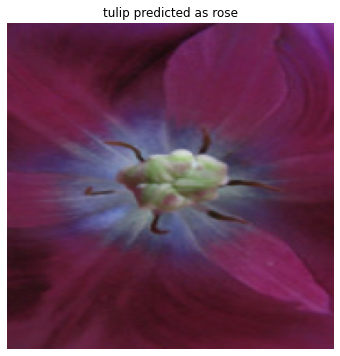

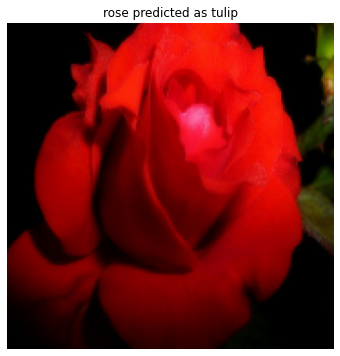

In [19]:
count = 0
for images, labels in test_ds.take(200):
    prediction = model.predict(images)
    predicted = np.argmax(prediction)
            
    real = np.argmax(labels)
            
    if predicted != real:
        plt.figure(figsize = (6, 6))
        t = class_names[real] + " predicted as " + class_names[predicted]
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.title(t)
        plt.axis("off")
        count += 1
    
    if count == 3:
        break
            